In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = glob.glob('camera_cal/calibration*.jpg')

# 1. Camera Calibration


In [2]:
def camera_cal(images):
    
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist





# 2. Distortion Correction¶


In [3]:
mtx, dist = camera_cal(images)
# apply undistorted function using transformation matrix and distortion coefficients
def undistort(img,mtx, dist):
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)  
    return dst

Text(0.5,1,'Undistorted Image')

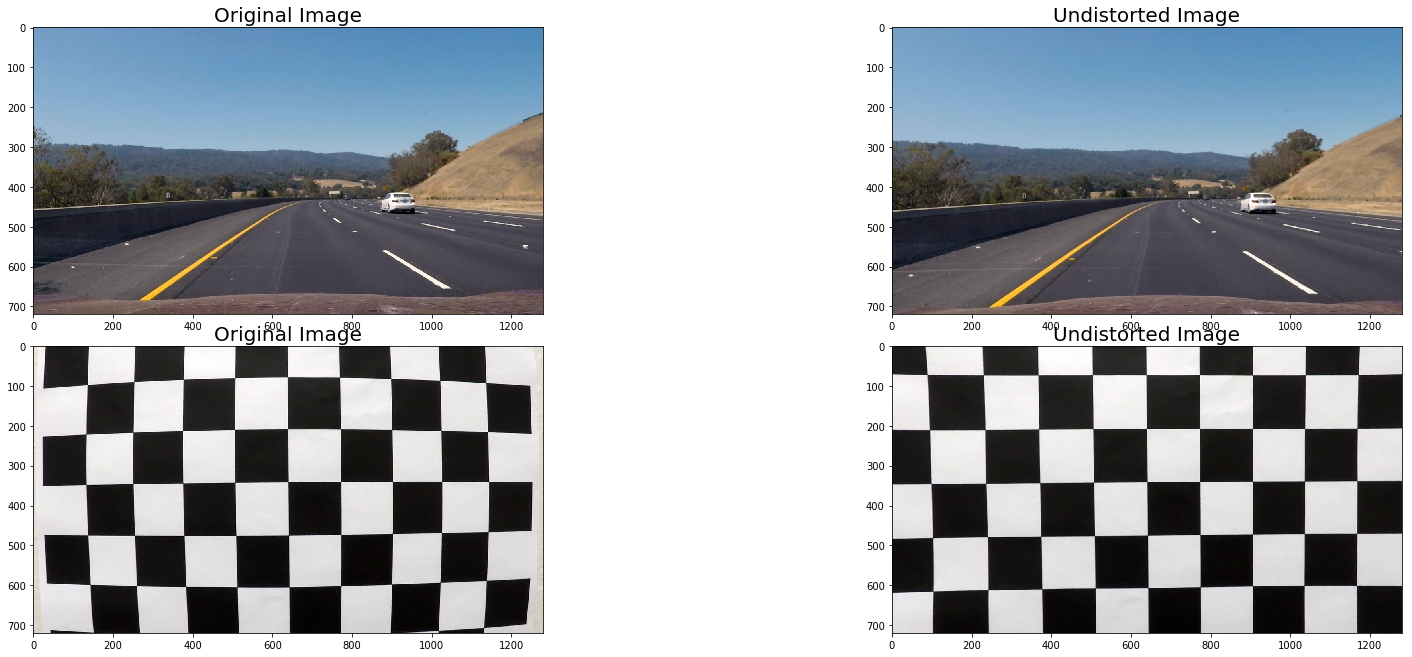

In [4]:
im1 = mpimg.imread('test_images/test3.jpg')
im2 = mpimg.imread('camera_cal/calibration1.jpg')

undist1 = undistort(im1,mtx, dist)
undist2 = undistort(im2,mtx, dist)


f, ax = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()

ax[0,0].imshow(im1,cmap='gray')
ax[0,0].set_title('Original Image', fontsize=20)

ax[0,1].imshow(undist1,cmap='gray')
ax[0,1].set_title('Undistorted Image', fontsize=20)

ax[1,0].imshow(im2,cmap='gray')
ax[1,0].set_title('Original Image', fontsize=20)

ax[1,1].imshow(undist2,cmap='gray')
ax[1,1].set_title('Undistorted Image', fontsize=20)

# 3. Color and Gradient Threshold


In [5]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Calculate directional gradient in x direction or in y direction
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0)
    else: #gradiant in y 
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1)
    
    sobel_abs = np.absolute(sobel)
    
    scaled_sobel = np.uint(255*sobel_abs / np.max(sobel_abs))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>= thresh[0])&(scaled_sobel<= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # calculate gradiant of the magnitude of sobel_x and sobel_y
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobelxy = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):

    # calculate gradiant of the direction of sobel_x and sobel_y
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    grad = np.arctan2(abs_y,abs_x)
    dir_binary = np.zeros_like(grad)
    dir_binary[(grad >=thresh[0])&(grad <=thresh[1])] = 1
    return dir_binary

def color_thresh(img,thresh=(150,255)):
    binary = np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary

# Gradient Threshold

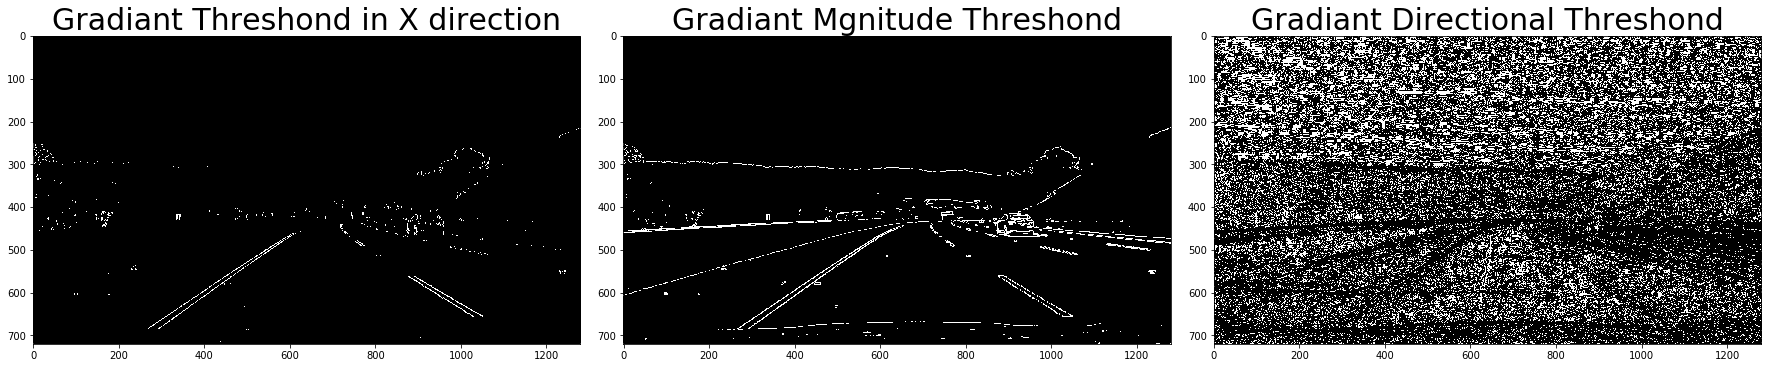

In [6]:
dst = np.copy(im1)

# Gradiant threholds 
sobelx_binary = abs_sobel_thresh(dst, orient='x', sobel_kernel=3, thresh=(50, 200))
mag_binary = mag_thresh(dst, sobel_kernel=3, mag_thresh=(50, 200))
dir_binary = dir_threshold(dst, sobel_kernel=3, thresh=(0,.25*np.pi/2))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(sobelx_binary,cmap='gray')
ax1.set_title('Gradiant Threshond in X direction', fontsize=30)

ax2.imshow(mag_binary,cmap='gray')
ax2.set_title('Gradiant Mgnitude Threshond', fontsize=30)

ax3.imshow(dir_binary,cmap='gray')
ax3.set_title('Gradiant Directional Threshond', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Color threholds 

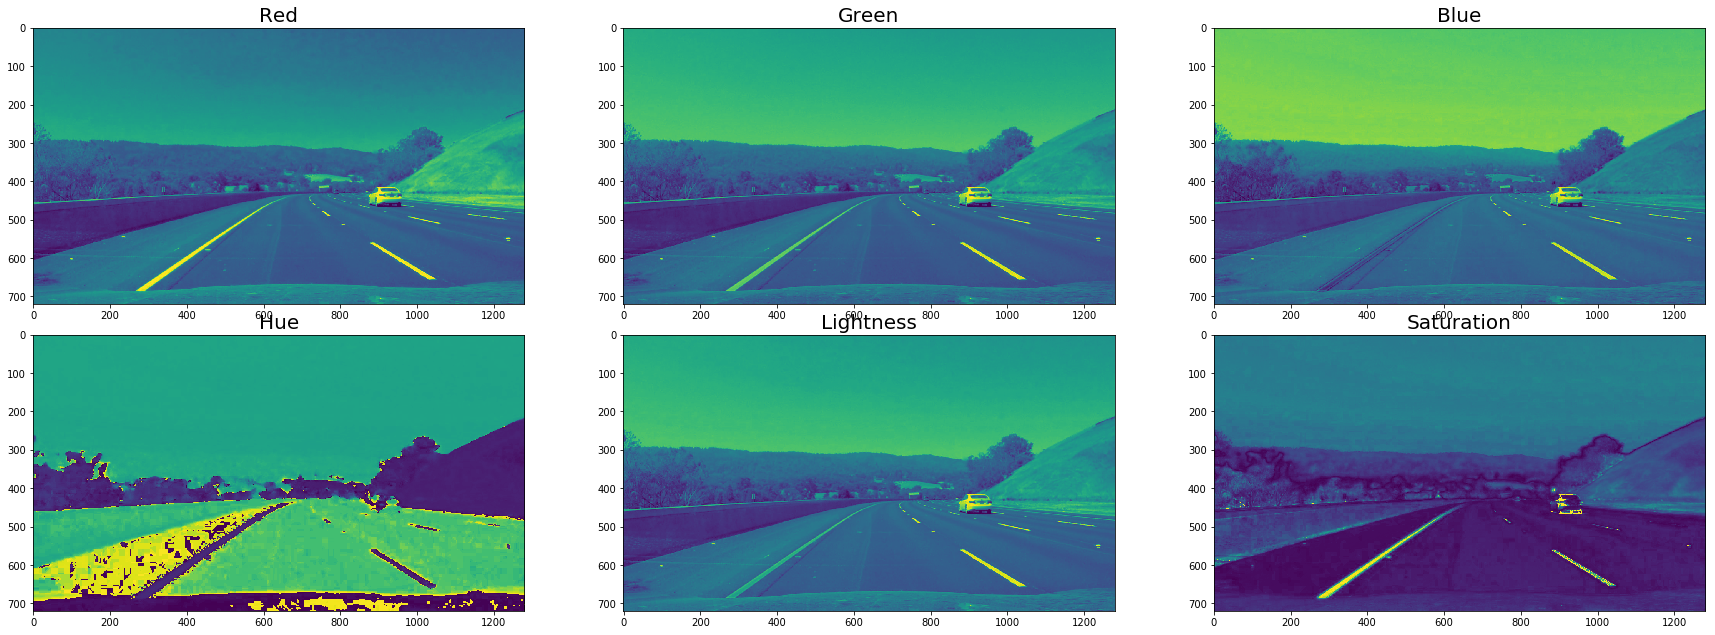

In [7]:
# seperate RGB channels 
R = dst[:,:,0]
G = dst[:,:,1]
B = dst[:,:,2]

#convert to HLS image space
dst_hls = cv2.cvtColor(dst,cv2.COLOR_RGB2HLS) 

# seperate HLS channels 
H = dst_hls[:,:,0]
L = dst_hls[:,:,1]
S = dst_hls[:,:,2]


f, ax = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()

ax[0,0].imshow(R)
ax[0,0].set_title('Red', fontsize=20)

ax[0,1].imshow(G)
ax[0,1].set_title('Green', fontsize=20)

ax[0,2].imshow(B)
ax[0,2].set_title('Blue', fontsize=20)

ax[1,0].imshow(H)
ax[1,0].set_title('Hue', fontsize=20)

ax[1,1].imshow(L)
ax[1,1].set_title('Lightness', fontsize=20)

ax[1,2].imshow(S)
ax[1,2].set_title('Saturation', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

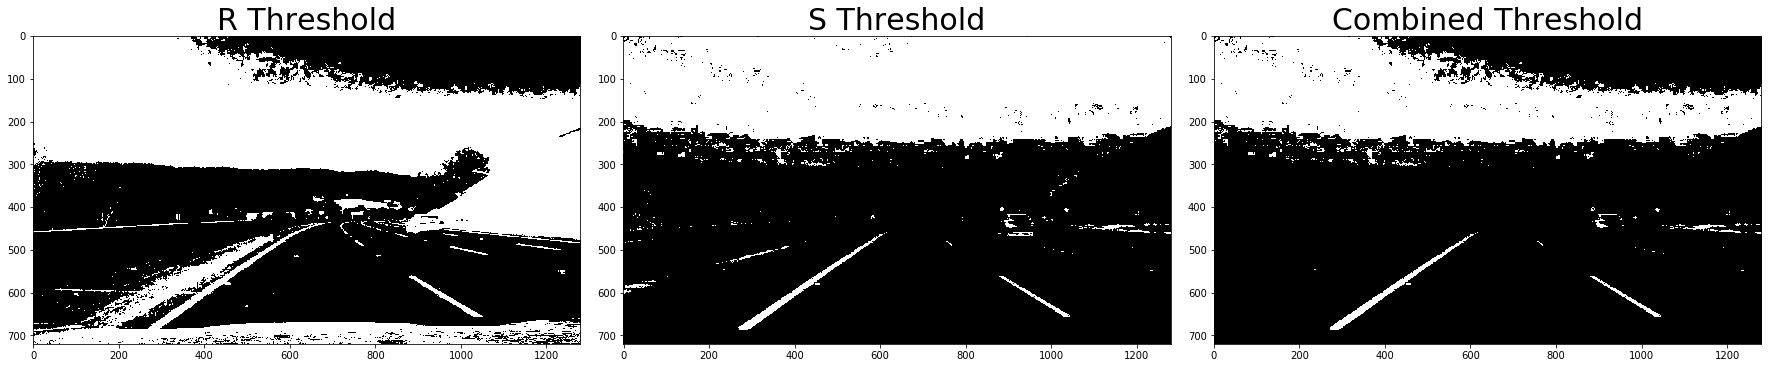

In [8]:
R_binary = color_thresh(R,thresh=(100,255))
S_binary = color_thresh(S,thresh=(100,255))

#I've tried diffrent thresholds combiations and I think R_chanel + S_channel is a good one
combined = np.zeros_like(R_binary)
#combined[((sobelx_binary == 1) & (mag_binary == 1)) | ((R_binary == 1) & (S_binary == 1))] = 1
combined[((R_binary == 1) & (S_binary == 1))] = 1


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(R_binary,cmap='gray')
ax1.set_title('R Threshold', fontsize=30)

ax2.imshow(S_binary,cmap='gray')
ax2.set_title('S Threshold', fontsize=30)

ax3.imshow(combined,cmap='gray')
ax3.set_title('Combined Threshold', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# 4. Perspective Transform

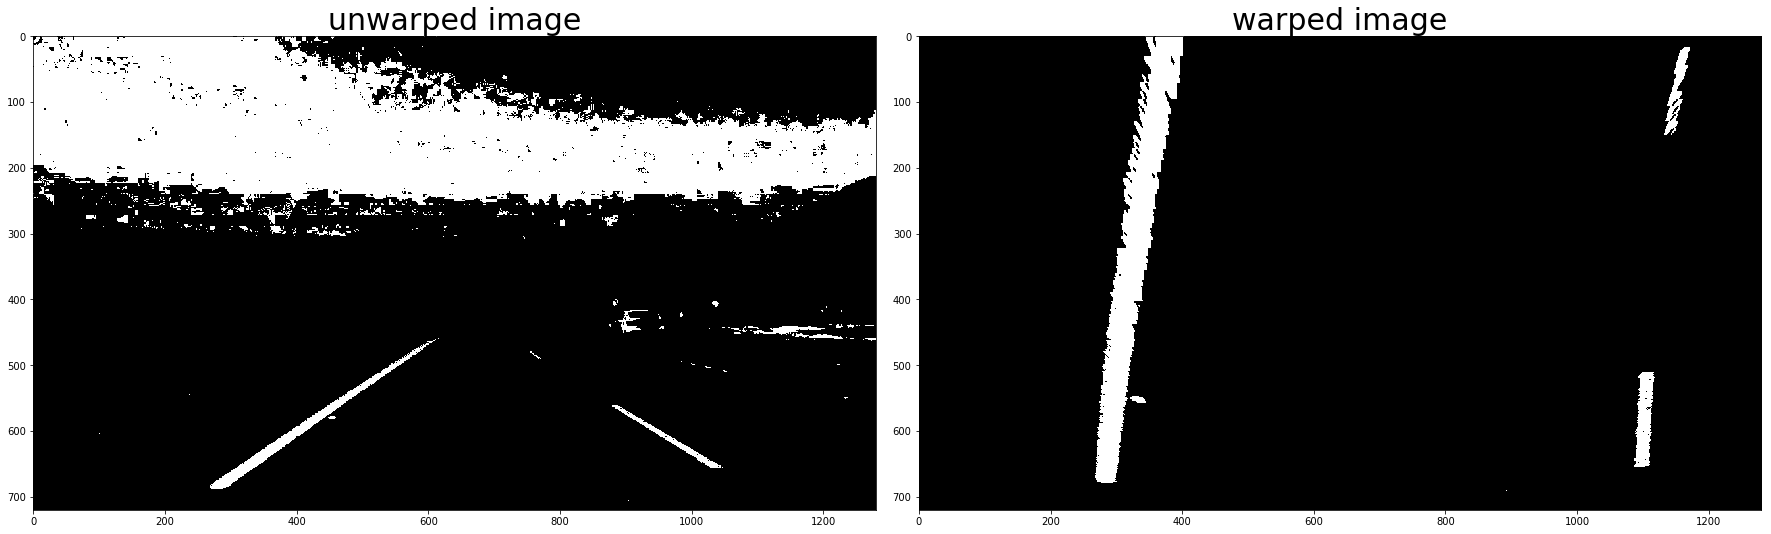

In [21]:
def warp(img):
    
    image_size = img.shape[1::-1]
    
    # Four source coordinates
    src = np.float32([[760,490],
                     [1100,690],
                     [280,690],
                     [550,490]])
    # Four desired coordinates
    dst = np.float32([[1100,155],
                     [1100,680],
                     [290,680],
                     [300,155]])
    
    # Compute the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    #apply that matrix on the image
    warped = cv2.warpPerspective(img, M, image_size)
    return warped

def unwarp(warped_image):
    
    image_size = warped_image.shape[1::-1]
      
    # Four source coordinates
    src = np.float32([[760,490],
                     [1100,690],
                     [280,690],
                     [550,490]])
    # Four desired coordinates
    dst = np.float32([[1100,155],
                     [1100,680],
                     [290,680],
                     [300,155]])
    # Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # unwarp the warped image - uses linear interpolation
    unwarped = cv2.warpPerspective(warped_image, Minv, image_size,flags = cv2.INTER_LINEAR)
    
    return unwarped 

warped = warp(combined)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined,cmap='gray')
ax1.set_title('unwarped image', fontsize=30)

ax2.imshow(warped,cmap='gray')
ax2.set_title('warped image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# 5. Preprocess the image 

In [11]:
def pipeline(image):
    # first let's get rid of camera distortion
    undistorted_image = undistort(image,mtx, dist)
    # let's change camera pespective into bird's eye view
    warped_image = warp(undistorted_image)

    # lets apply thresholding to S and R channels
    R = warped_image[:,:,0]
    HLS = cv2.cvtColor(warped_image,cv2.COLOR_RGB2HLS)
    S = HLS[:,:,2]
    R_binary = color_thresh(R,thresh=(100,255))
    S_binary = color_thresh(S,thresh=(100,255))
    combined = np.zeros_like(R_binary)
    combined[((R_binary == 1) & (S_binary == 1))] = 1
 
    # creating a three channel  image from our 1 channel binary(B&W) Image
    three_channel_thresholded_image = np.dstack((combined,combined,combined))*255
    return three_channel_thresholded_image

# 6. Line Fitting using sliding window


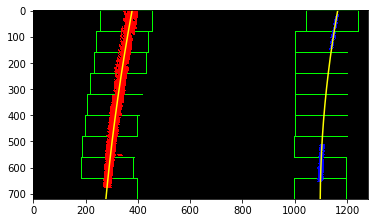

In [16]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img




out_img = fit_polynomial(warped)

plt.imshow(out_img)

# 7.Lane Detector

In [19]:
# highlights the lane in the original video stream
def lane_detector(image):
    
    # process the image to undistort, apply s and sobel thresholding 
    # and warp it into the bird's eye view
    processed_image = pipeline(image)
    
    histogram = np.sum(processed_image[:,:,0],axis = 0)
    # find the peaks of the left and right halves of the histogram
    # as the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    # Hyperparameters
    # choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set the minimum number of the pixels to recenter the windows 
    minpix = 50
    # Set height of the windows - based on nwindows above and image shape
    window_height = processed_image.shape[0] // nwindows
    
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = processed_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        #Identify window boundaries in x and y
        win_y_low = processed_image.shape[0] - (window+1)*window_height
        win_y_high = processed_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin


        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists 
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        #if more than minpix pixels were found , recenter next window on their mean position 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    # Generate x and y values for plotting
    ploty = np.linspace(0, processed_image.shape[0]-1, processed_image.shape[0])
    try:
        # Fit a second order polynomial to each set of lane points
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    # Highlightign the left and right lane regions 
    # drawing the left and right polynomials on the lane lines
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    blank_image = np.zeros_like(processed_image)
    # Draw the lane onto a blank warped image
    cv2.fillPoly(blank_image, np.int_([pts]), (0,255, 0))
    
    # change the perspective back into the original view
    unwarped_image = unwarp(blank_image)
    
    # add the unwarped processed image to the original image
    weighted_image = cv2.addWeighted(image, 1.0, unwarped_image, .7, 0)
    return weighted_image


# 8. Measure curvature

In [28]:
def measure_curvature(ploty,leftx ,lefty, rightx, righty):
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3*10/720 # meters per pixel in y dimension
                         # (we're projecting roughly 10 dashed line into 720pixels,
                         # each dashed line is 3 m per standards)
    xm_per_pix = 3.7/800 # meters per pixel in x dimension(3.7 m is the standar us lane width)
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval_left = np.max(ploty)
    y_eval_right = np.max(ploty)

    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_left*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_right*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad
    


# highlights the lane in the original video stream

def highlight_lane_original(image):
    
    # process the image to undistort, apply s and sobel thresholding 
    # and warp it into the bird's eye view
    processed_image = pipeline(image)
    
    histogram = np.sum(processed_image[:,:,0],axis = 0)
    # find the peaks of the left and right halves of the histogram
    # as the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    # Hyperparameters
    # choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set the minimum number of the pixels to recenter the windows 
    minpix = 50
    # Set height of the windows - based on nwindows above and image shape
    window_height = processed_image.shape[0] // nwindows
    
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = processed_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        #Identify window boundaries in x and y
        win_y_low = processed_image.shape[0] - (window+1)*window_height
        win_y_high = processed_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin


        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists 
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        #if more than minpix pixels were found , recenter next window on their mean position 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    # Generate x and y values for plotting
    ploty = np.linspace(0, processed_image.shape[0]-1, processed_image.shape[0])
    try:
        # Fit a second order polynomial to each set of lane points
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    blank_image = np.zeros_like(processed_image)
    # Draw the lane onto a blank warped image
    cv2.fillPoly(blank_image, np.int_([pts]), (0,255, 0))
    
    # change the perspective back into the original view
    unwarped_image = unwarp(blank_image)
    
    # add the unwarped processed image to the original image
    weighted_image = cv2.addWeighted(image, 1.0, unwarped_image, .3, 0)
    
    # calculate the curvature of curve:
    left_curverad, right_curverad = measure_curvature(ploty,leftx ,lefty, rightx, righty)
    
    # write the curvature values on the frame
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (100,100)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    left_curvature_text = 'Left Curvature: '+ '{:04.2f}'.format(left_curverad)+ ' m'
    right_curvature_text = '   Right Curvature: ' +'{:04.2f}'.format(right_curverad)+ ' m'
    curvature_text = left_curvature_text + right_curvature_text
    cv2.putText(weighted_image,
                curvature_text,
                bottomLeftCornerOfText, 
                font, 
                fontScale,
                fontColor,
                lineType)
    
    # calculate offset
    # find x values of leftftix and rightfitx at the bottom of the image (y max) and 
    # find the mid point between left and right lane
    y_eval = np.max(ploty)
    x_left_eval = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    x_right_eval = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    car_location = x_left_eval+(x_right_eval - x_left_eval) / 2
    car_offset = image.shape[1] / 2 - car_location
    xm_per_pix = 3.7/800
    car_offset_meter = car_offset *xm_per_pix
    if car_offset_meter <= 0 :
        direction = 'right of center'
    else:
        direction = 'left of center'
    car_offset_text = 'Car offset: '+ '{:04.3f}'.format(abs(car_offset_meter)) +' m ' +direction
    cv2.putText(weighted_image,
                car_offset_text,
                (100,200), 
                font, 
                fontScale,
                fontColor,
                lineType)
    
    return weighted_image


In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
output_file_path = 'project_video_final.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
input_video = VideoFileClip("project_video.mp4").subclip(0,15)
output_video = input_video.fl_image(highlight_lane_original) #NOTE: this function expects color images!!
%time output_video.write_videofile(output_file_path, audio=False)

[MoviePy] >>>> Building video project_video_final.mp4
[MoviePy] Writing video project_video_final.mp4


100%|█████████▉| 375/376 [00:56<00:00,  6.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_final.mp4 

CPU times: user 43.8 s, sys: 2.01 s, total: 45.8 s
Wall time: 57 s


In [ ]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(output_file_path))